# Markov Chain Monte Carlo (MCMC)

MCMC is a way to find the posterior distribution through Bayes Theorem without needing to solve the denominator of the equation, $P(data)$.

To review, Bayes Theorem states:

### $$ P(model\;|\;data) = \frac{P(data\;|\;model)}{P(data)}\;P(model) $$

Where $P(model\;|\;data)$ is the **posterior distribution of the model**

$P(data\;|\;model)$ is the **likelihood of the data given the model**

$P(data)$ is the **total probability of the data**, or the probability of the data occurring across all models

and $P(model)$ is the **prior distribution of the model**

---

### When solving Bayes Theorem is intractable...

Bayes Theorem is designed to "update" our prior distribution to a posterior distribution, and both of those distributions are probability density functions.

We've been looking at situations like coin flips where solving the theorem actually has an equation for the different components, but there are many situations where the posterior cannot be directly solved.

With $P(data)$, for example, we need to get the likelihood of the data across _all possible models_. With a coin flip, we can integrate between 0 and 1 for all possible weightings of the coin, but what about something more complicated like the number of minutes a flight is delayed?

MCMC is designed to let us still get the posterior distribution estimate without needing to actually solve the equation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as stats

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

### Load airline data

This dataset contains information on airports, year, and various metrics related to how delayed or not flights were.

In [2]:
air = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-2/datasets/airport/airport_operations.csv')
air.columns = [c.replace(' ','_').replace('-','_') for c in air.columns]
air.head(2)

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


---

### Calculate the mean delay and plot the delays

In [3]:
delay = air.average_airport_departure_delay.values
mean_delay = np.mean(delay)
print mean_delay, len(delay)

16.2499643282 841


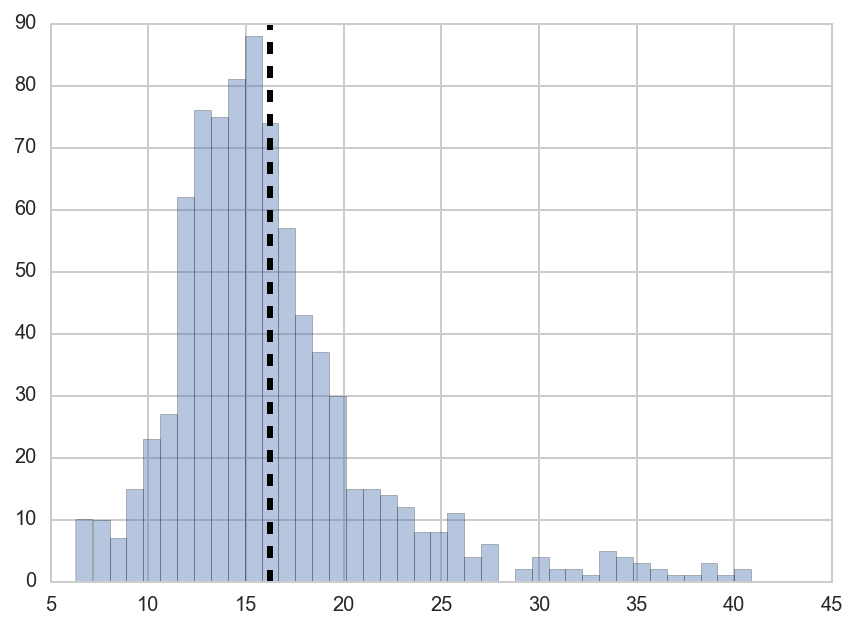

In [5]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca()

ax = sns.distplot(delay, bins=40, ax=ax, kde=False)
ax.axvline(mean_delay, lw=3, ls='dashed', color='black')
plt.show()

---

### Construct a prior belief distribution about possible delay times

Below I'm going to say that I believe flights are on average delayed 20 minutes. I will model my belief with a normal distribution and say that there is a 5 minute standard deviation around that 20 minute mean.

In [6]:
delay_belief_mean = 20.
delay_belief_std = 5.

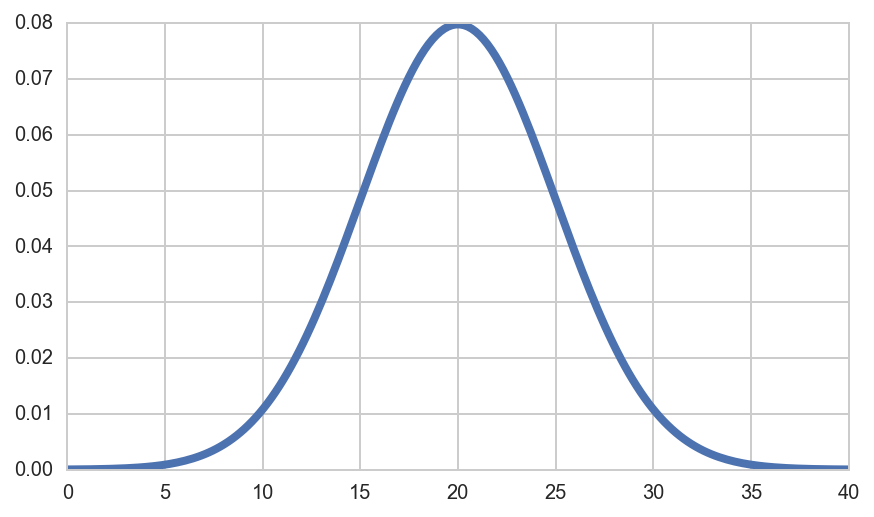

In [8]:
fig, ax = plt.subplots(figsize=(7,4))
minute_range = np.linspace(0, 40, 200)

# normally distributed belief about average delay times:
prior = stats.norm(delay_belief_mean, delay_belief_std)
minute_pdfs = prior.pdf(minute_range)

ax.plot(minute_range, minute_pdfs, lw=4)
plt.show()


In [11]:
prior.cdf(25) - prior.cdf(15)

0.68268949213708585

In [13]:
prior.pdf(20.)/prior.pdf(25.)

1.648721270700128

---

### Log likelihood of the data

Recall that we have a component of Bayes Theorem that represents the likelihood of the data given our model:

### $$ P(data\;|\;model) $$

What is this representing? **Our "model" in this case is the distribution of the possible mean delays.** We are modeling delay times with a distribution of possible mean delay times and nothing more. It is not as complicated a model as a regression with multiple predictors, but a model nonetheless.

To calculate the likelihood of the data given our model we need to ask: how likely would a datapoint (delay) be to occur according to our model?

Below I'll write a function to calculate the sum of the log of probability densities at each of our delay data points. This will be the aggregate likelihood across all the delays.

Why the log of the probability densities? Often likelihoods are so tiny that the computer has a difficult time working with the numbers. Converting these to log format puts them in terms of orders of magnitude and makes sure the computer doesn't break doing the calculations.

In [14]:
def log_likelihood_data(data, proposed_mean, proposed_std):
    distribution = stats.norm(proposed_mean, proposed_std)
    log_likelihood = distribution.logpdf(data)
    return log_likelihood

In [16]:
five_delays = delay[0:5]
five_delays

array([ 12.1 ,  11.2 ,  12.33,  12.95,  12.32])

In [24]:
np.sum(log_likelihood_data(five_delays, 18, 5))

-16.061158228193865

In [19]:
np.sum(log_likelihood_data(five_delays, 12, 5))

-12.677158228193864

In [27]:
np.exp(np.sum(log_likelihood_data(five_delays, 15, 5)) - \
       np.sum(log_likelihood_data(five_delays, 13, 5)))

0.4828737725312307

---

### Plot the log likelihood of the data given our current belief about mean and standard deviation of delays

In [31]:
# Redefine to return sum of log likelihoods:
def log_likelihood_data(data, proposed_mean, proposed_std):
    distribution = stats.norm(proposed_mean, proposed_std)
    log_likelihood = distribution.logpdf(data)
    return np.sum(log_likelihood)

In [38]:
def plot_loglike_data(data, proposed_mean, proposed_std):
    
    # default for plt.subplots is plt.subplots(1, 1)
    # which is 1 row, 1 column, and so its just 1 axis object
    fig = plt.figure(figsize=(7,4))
    ax = fig.gca()
    
    ax = sns.distplot(data, bins=40, ax=ax)
    
    proposal_xrange = np.linspace(np.min(data)-2, np.max(data)+2, 200)
    belief_dist = stats.norm(proposed_mean, proposed_std)
    proposal_pdf = belief_dist.pdf(proposal_xrange)
    
    log_like = log_likelihood_data(data, proposed_mean, proposed_std)
    
    ax.plot(proposal_xrange, proposal_pdf, lw=4, color='darkred',
            label='log like: '+'{0:.3f}'.format(log_like))
    
    ax.legend(loc='upper left')
    plt.show()

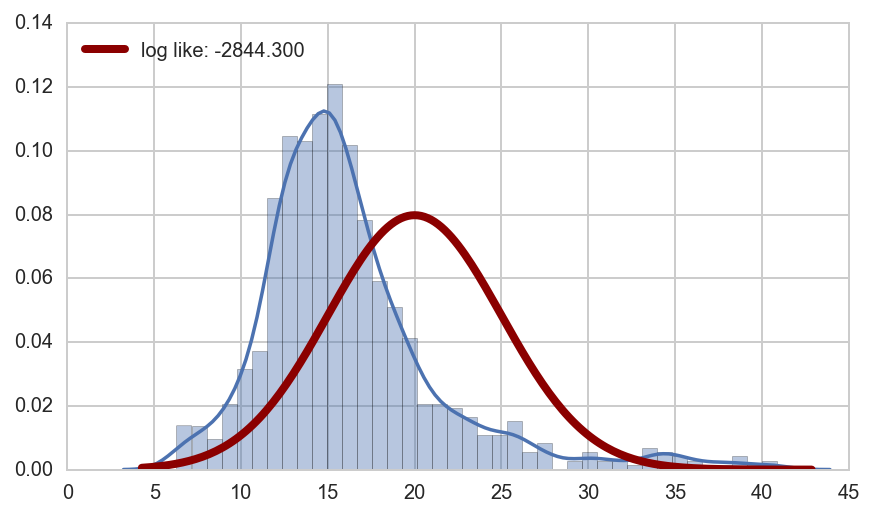

In [42]:
plot_loglike_data(delay, 20, 5)

---

### Checking proposals about different delays

MCMC at the core is all about checking different likelihoods of the data (and your prior) for different versions of your model. 

Right now we believe that the mean delay is 20. How much would the likelihood $P(data\;|\;model)$ change if that mean were instead 30? Would this likelihood be larger or smaller?

We can use the likelihood function we wrote above to check any new parameter, but we need a system for making new proposals. In MCMC the parameter is moved at random in small increments. In this case we will draw a new number from a normal distribution with a mean that is our current value and small standard deviation. This will either move the distribution slightly to the left or to the right.

In this example we're only going to explore different possibilities for the mean and leave the standard deviation of the delay fixed, but really any parameter can be allowed to vary except for the data itself.

In [43]:
def get_new_proposal(proposal_distribution_mean, proposal_distribution_std):
    proposal_distribution = stats.norm(proposal_distribution_mean, proposal_distribution_std)
    new_proposed_statistic = proposal_distribution.rvs()
    return new_proposed_statistic

In [55]:
np.random.rand()

0.33038020064591533

---

### Plot a proposal shift from mean delay 20 to mean delay 30

In [48]:
def plot_proposal_move(data, old_mean, new_mean, fixed_std):
    
    fig = plt.figure(figsize=(7,4))
    ax = fig.gca()
    
    ax = sns.distplot(data, bins=40, ax=ax)
    proposal_xrange = np.linspace(np.min(data)-2, np.max(data)+2, 200)
    
    old_pdf = stats.norm(old_mean, fixed_std).pdf(proposal_xrange)
    new_pdf = stats.norm(new_mean, fixed_std).pdf(proposal_xrange)
    
    old_loglike = log_likelihood_data(data, old_mean, fixed_std)
    new_loglike = log_likelihood_data(data, new_mean, fixed_std)
    
    ax.plot(proposal_xrange, old_pdf, lw=4, color='darkred', alpha=0.3,
            label='old LL: '+'{0:.3f}'.format(old_loglike))
    ax.plot(proposal_xrange, new_pdf, lw=4, color='darkred', alpha=1.0,
            label='new LL: '+'{0:.3f}'.format(new_loglike))
    
    ax.legend(loc='upper left')
    plt.show()
    

20 19.2750189461


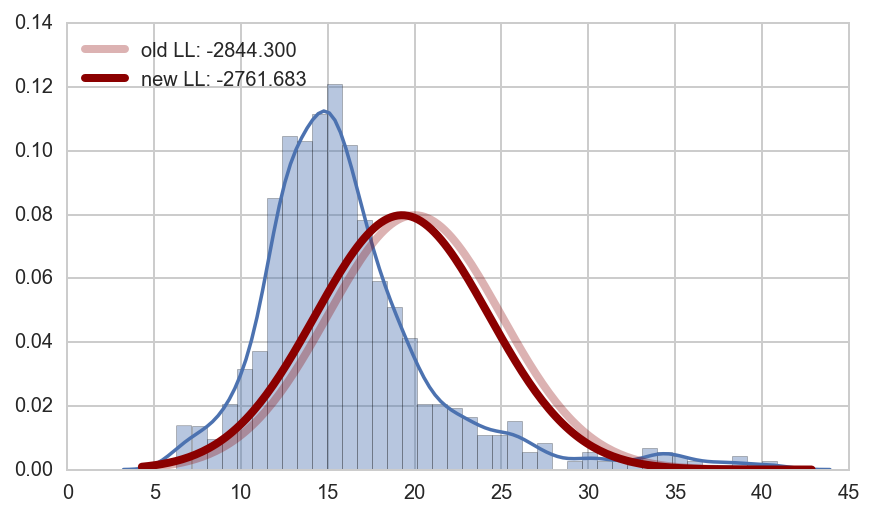

In [56]:
new_proposed_mean = get_new_proposal(20, 5)
print 20, new_proposed_mean
plot_proposal_move(delay, 20, new_proposed_mean, 5)

---

### Log likelihood of the prior

We are also going to want to see how likely our new proposed mean is on our prior belief about the mean delays. For example, a mean delay of 100 minutes would be highly unlikely on our prior distribution of beliefs about how much flights can be delayed on average.

In [57]:
def log_likelihood_prior(proposed_mean, prior_belief_mean, prior_belief_std):
    prior = stats.norm(prior_belief_mean, prior_belief_std)
    proposed_loglike = prior.logpdf(proposed_mean)
    return proposed_loglike

In [62]:
log_likelihood_prior(-100, 20, 5)

-290.52837644563874

---

### Plot the log likelihood of a delay of 30 minutes on our prior belief about mean delays

In [71]:
def plot_prior_loglike(proposed_mean, prior_mean, prior_std):
    
    fig = plt.figure(figsize=(7,4))
    ax = fig.gca()
    x_range = np.linspace(0, 40, 200)
    
    prior = stats.norm(prior_mean, prior_std)
    prior_pdf = prior.pdf(x_range)
    proposed_likelihood = prior.pdf(proposed_mean)
    proposed_loglike = log_likelihood_prior(proposed_mean, prior_mean, prior_std)
    
    ax.plot(x_range, prior_pdf, lw=4)
    ax.scatter(proposed_mean, proposed_likelihood, color='darkred', s=200,
               label='proposed prior LL: '+'{0:.3f}'.format(proposed_loglike))
    
    ax.legend(loc='upper left')
    plt.show()

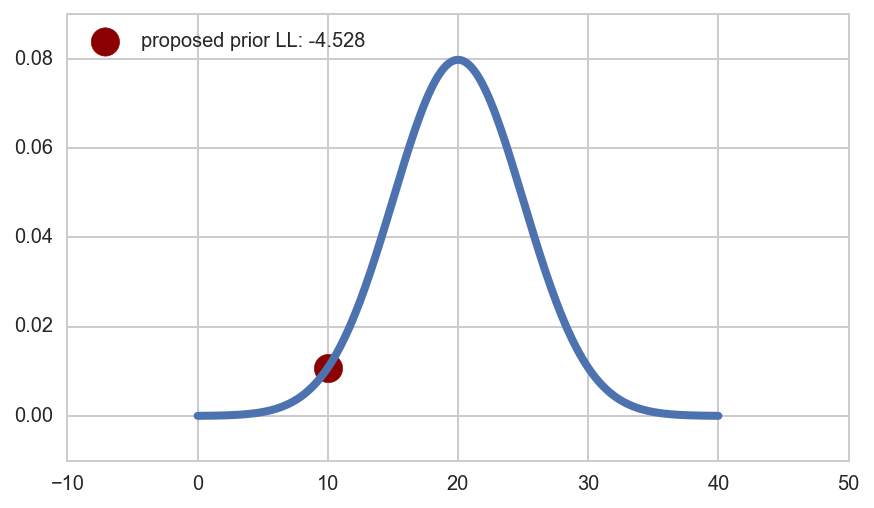

In [75]:
plot_prior_loglike(10, 20, 5)

---

### Metropolis-Hastings sampler

Now we can actually start to do the core MCMC process. You've seen in pymc3 the NUTS sampler, which is a more advanced way of doing MCMC. We are going to use the original sampling process called Metropolis-Hastings.

How do we get rid of the denominator in Bayes equation, $P(data)$, that makes problems impossible to compute?

Let's consider two different specific proposals for the mean delay, model1 and model2. We can write out the equations for the posterior probability of both when we consider those proposals against the data:

### $$ P(model_1\;|\;data) = \frac{P(data\;|\;model_1)}{P(data)}\;P(model_1) $$

### $$ P(model_2\;|\;data) = \frac{P(data\;|\;model_2)}{P(data)}\;P(model_2) $$

MCMC uses the idea that we can compare the _relative likelihoods_ of each model by dividing one by the other:

### $$ \frac{\frac{P(data\;|\;model_1)\;P(model_1)}{P(data)}}{\frac{P(data\;|\;model_2)\;P(model_2)}{P(data)}}  = \frac{P(data\;|\;model_1)\;P(model_1)}{P(data\;|\;model_2)\;P(model_2)} $$

Which is the same as saying we are dividing the posterior of one of the models by the posterior of the other model. This cancels out the $P(data)$ component that we didn't have any equation to compute before.

But this doesn't get us all of the way there yet. The part that makes MCMC work for finding the posterior density is that it uses this equation above to _visit models with relatively higher likelihood more often._ 

**The acceptance criterion:**

Once you have the relative likelihood of each model given the data, you can compare that to a random number between 0 and 1:

    acceptance_criterion = (proposal_likelihood / current_likelihood)
    or
    acceptance_criterion = e^(proposal_log_likelihood - current_log_likelihood)
    
    if acceptance_criterion > 1:
        accept the proposed model
    else:
    
        random_fraction = np.random.rand()  # lies between 0.0 and 1.0

        if acceptance_criterion > random_fraction:
            accept the proposed model
        else:
            accept the current model
        
If the proposed model has a _higher_ likelihood than the current model, the acceptance criterion will always be above one and it will always accept the proposed model as the new current model.

If the proposed model has a _lower_ likelihood than the current model, then it has a chance of becoming the new current model with a probability proportional to relatively how much lower its likelihood is.

In [76]:
def metropolis_sampler(data, current_mean, prior_mean, prior_std):
    # 1. figure out P(data|current_mean) --> likelihood of data
    current_data_loglike = log_likelihood_data(data, current_mean, prior_std)
    # 2. figure out P(current_mean) on prior distribution
    current_prior_loglike = log_likelihood_prior(current_mean, prior_mean, prior_std)
    # 3. combine this into the likelihood of the current mean
    current_loglike = (current_data_loglike + current_prior_loglike)
    
    # 4. get a proposal for a new mean to consider:
    proposed_mean = get_new_proposal(current_mean, 0.2)
    
    # 5. P(data|proposed_mean) 
    proposed_data_loglike = log_likelihood_data(data, proposed_mean, prior_std)
    # 6. P(proposed_mean) on prior distribution
    proposed_prior_loglike = log_likelihood_prior(proposed_mean, prior_mean, prior_std)
    # 7. combine into proposed likelihood
    proposed_loglike = (proposed_data_loglike + proposed_prior_loglike)
    
    # 8. LL(proposed) / LL(current)
    # this will be from 0 to inf.
    acceptance_criterion = np.exp(proposed_loglike - current_loglike)
    
    # 9. get a random number between 0 and 1
    random_fraction = np.random.rand()
    
    # 10. accept if over random_fraction
    if acceptance_criterion > random_fraction:
        return proposed_mean
    else:
        return current_mean
    

---

### MCMC

For the final MCMC function, we just need to supply:

1. the data
2. the initial information about our model (in this case, the initial mean delay proposal)
3. the information about the prior distribution
4. the number of iterations

It will wrap the Metropolis-Hastings sampler and run it on each iteration. Recall that the sampler will return the current accepted model (mean). We append this to the list of posterior means and use it as the new current mean for the next iteration of the sampler.

In [77]:
def mcmc(data, initial_proposal, prior_mean, prior_std, iterations=1000):
    
    # 1. keep track of the accepted means:
    accepted_means = [initial_proposal]
    current_mean = initial_proposal
    
    for i in range(iterations):
        if (i % 250) == 0:
            print 'Iteration:', i
        
        current_mean = metropolis_sampler(data, current_mean, prior_mean, prior_std)
        accepted_means.append(current_mean)
        
    return accepted_means
    

---

### Run MCMC on the delay data

In [90]:
posterior = mcmc(delay, 20, 20, 0.01, iterations=2000)

Iteration: 0
Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 1000
Iteration: 1250
Iteration: 1500
Iteration: 1750


---

### Plot the posterior means

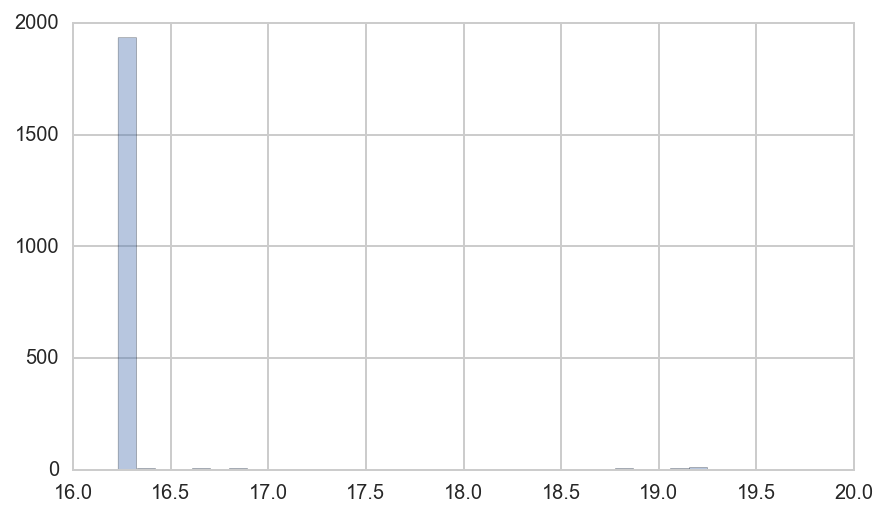

In [91]:
fig, ax = plt.subplots(figsize=(7,4))
ax = sns.distplot(posterior, bins=40, kde=False)
delay_mins = np.linspace(10, 30, 200)
prior = stats.norm(20, 5)
prior_pdf = prior.pdf(delay_mins)
#ax.plot(delay_mins, prior_pdf, color='darkred', lw=2.5)
plt.show()

In [92]:
print np.mean(posterior), np.mean(delay)

16.3173255045 16.2499643282
